# Problem 5: Causal Masking - Interactive Notebook

Explore how causal masking enables autoregressive language modeling.

## Setup

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# When finished, uncomment the following sentence and import your own solution
from solution import CausalMultiHeadAttention
# from problem import CausalMultiHeadAttention
# We'll also import non-causal version for comparison
# When finished, uncomment the following sentence and import your own solution
from solution import MultiHeadAttention
# from problem import MultiHeadAttention

torch.manual_seed(42)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print('Setup complete!')

Setup complete!


## Visualize the Causal Mask

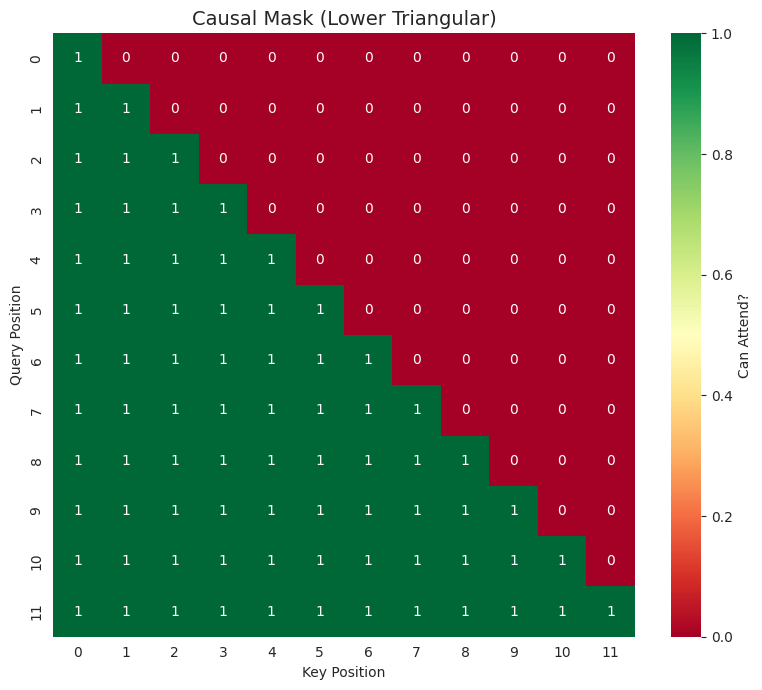

1 = Can attend, 0 = Cannot attend (masked)
Each position can only see itself and previous positions!


In [2]:
# Create attention module and extract mask
attn = CausalMultiHeadAttention(n_embd=64, n_head=4, n_positions=12)

mask = attn.bias.squeeze().numpy()

plt.figure(figsize=(8, 7))
sns.heatmap(mask, annot=True, fmt='.0f', cmap='RdYlGn', 
            cbar_kws={'label': 'Can Attend?'},
            xticklabels=range(12), yticklabels=range(12))
plt.title('Causal Mask (Lower Triangular)', fontsize=14)
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.tight_layout()
plt.show()

print('1 = Can attend, 0 = Cannot attend (masked)')
print('Each position can only see itself and previous positions!')

## Compare: Causal vs Bidirectional Attention

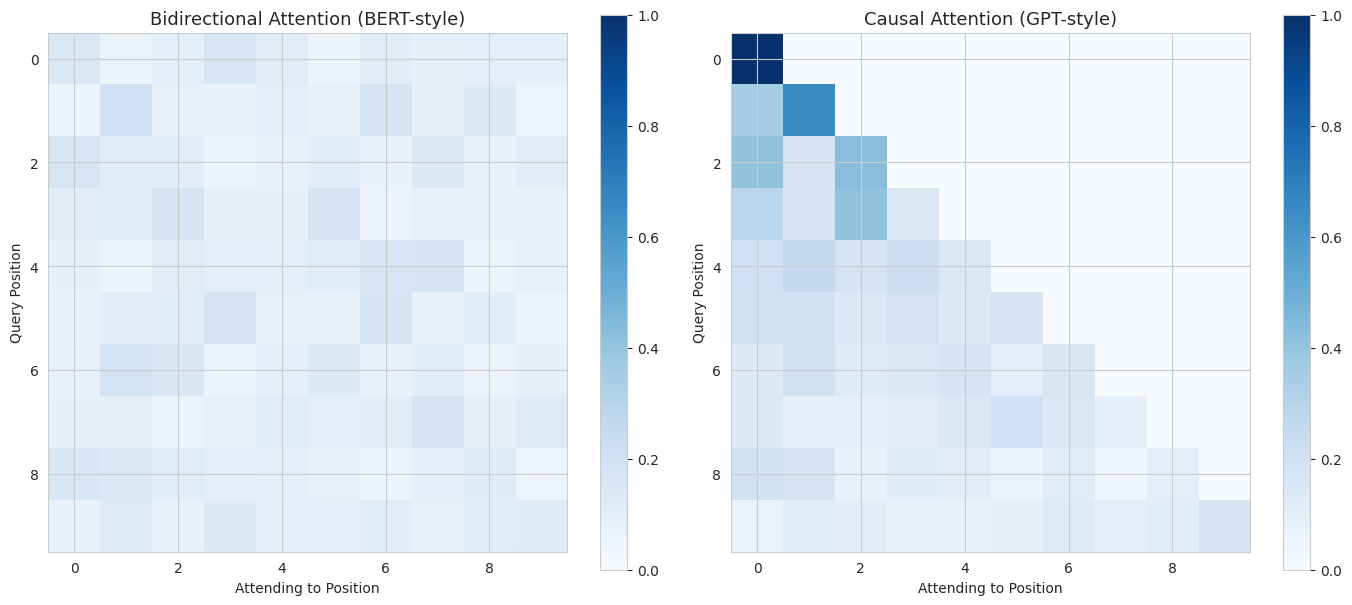

Notice the triangular pattern in causal attention!


In [3]:
# Helper to extract attention weights
class CausalAttnWithWeights(CausalMultiHeadAttention):
    def forward(self, x):
        batch_size, seq_len, n_embd = x.size()
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        q = q.view(batch_size, seq_len, self.n_head, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.n_head, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.n_head, self.head_dim).transpose(1, 2)

        attn_scores = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_scores = attn_scores.masked_fill(
            self.bias[:, :, :seq_len, :seq_len] == 0, float("-inf")
        )
        attn_weights = torch.softmax(attn_scores, dim=-1)
        out = attn_weights @ v
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, n_embd)
        out = self.c_proj(out)
        return out, attn_weights

class BiAttnWithWeights(MultiHeadAttention):
    def forward(self, x):
        batch_size, seq_len, n_embd = x.size()
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        q = q.view(batch_size, seq_len, self.n_head, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.n_head, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.n_head, self.head_dim).transpose(1, 2)

        attn_scores = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        out = attn_weights @ v
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, n_embd)
        out = self.c_proj(out)
        return out, attn_weights

# Create both types
n_embd, n_head, seq_len = 128, 4, 10
causal_attn = CausalAttnWithWeights(n_embd=n_embd, n_head=n_head, dropout=0.0)
bidir_attn = BiAttnWithWeights(n_embd=n_embd, n_head=n_head, dropout=0.0)

causal_attn.eval()
bidir_attn.eval()

x = torch.randn(1, seq_len, n_embd)

with torch.no_grad():
    _, causal_weights = causal_attn(x)
    _, bidir_weights = bidir_attn(x)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bidirectional (head 0)
im1 = axes[0].imshow(bidir_weights[0, 0].numpy(), cmap='Blues', vmin=0, vmax=1)
axes[0].set_title('Bidirectional Attention (BERT-style)', fontsize=13)
axes[0].set_xlabel('Attending to Position')
axes[0].set_ylabel('Query Position')
plt.colorbar(im1, ax=axes[0])

# Causal (head 0)
im2 = axes[1].imshow(causal_weights[0, 0].numpy(), cmap='Blues', vmin=0, vmax=1)
axes[1].set_title('Causal Attention (GPT-style)', fontsize=13)
axes[1].set_xlabel('Attending to Position')
axes[1].set_ylabel('Query Position')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

print('Notice the triangular pattern in causal attention!')

## Autoregressive Generation Simulation

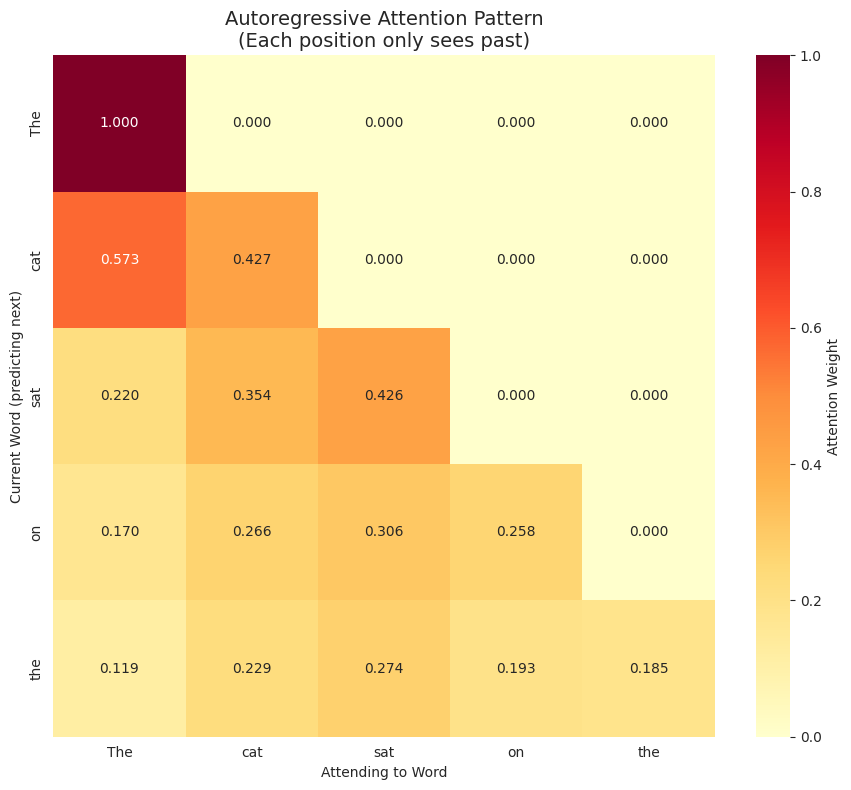


How each word predicts the next:
0. "The" can see: The
1. "cat" can see: The, cat
2. "sat" can see: The, cat, sat
3. "on" can see: The, cat, sat, on
4. "the" can see: The, cat, sat, on, the


In [4]:
# Simulate text generation
# Sentence: "The cat sat on the"
tokens = ["The", "cat", "sat", "on", "the"]
seq_len = len(tokens)

causal_attn_viz = CausalAttnWithWeights(n_embd=64, n_head=1, dropout=0.0)
causal_attn_viz.eval()

x = torch.randn(1, seq_len, 64)

with torch.no_grad():
    _, weights = causal_attn_viz(x)

weights = weights.squeeze().numpy()

plt.figure(figsize=(9, 8))
sns.heatmap(weights, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=tokens, yticklabels=tokens,
            cbar_kws={'label': 'Attention Weight'})
plt.title('Autoregressive Attention Pattern\n(Each position only sees past)', fontsize=14)
plt.xlabel('Attending to Word')
plt.ylabel('Current Word (predicting next)')
plt.tight_layout()
plt.show()

print('\nHow each word predicts the next:')
for i, token in enumerate(tokens):
    context = tokens[:i+1]
    print(f'{i}. "{token}" can see: {", ".join(context)}')

## Attention Weights Per Position

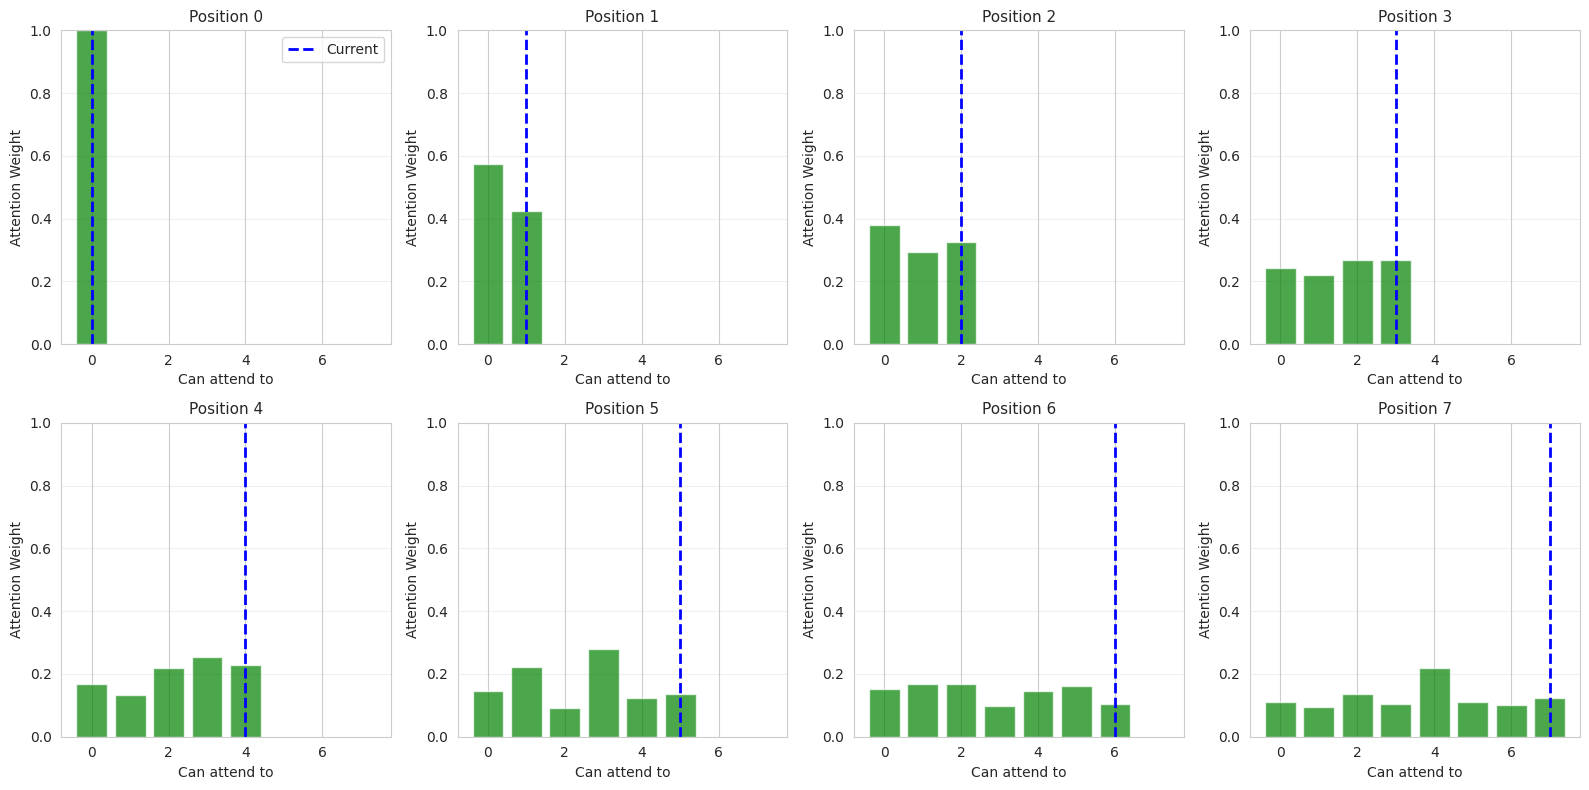

Green = Can attend | Red = Masked (future positions)


In [5]:
# Show how attention changes by position
seq_len = 8
causal_attn = CausalAttnWithWeights(n_embd=64, n_head=1, dropout=0.0)
causal_attn.eval()

x = torch.randn(1, seq_len, 64)

with torch.no_grad():
    _, weights = causal_attn(x)

weights_np = weights.squeeze().numpy()

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for pos in range(seq_len):
    # Show attention distribution for this position
    attn_dist = weights_np[pos]
    
    colors = ['green' if i <= pos else 'red' for i in range(seq_len)]
    axes[pos].bar(range(seq_len), attn_dist, color=colors, alpha=0.7)
    axes[pos].set_title(f'Position {pos}', fontsize=11)
    axes[pos].set_xlabel('Can attend to')
    axes[pos].set_ylabel('Attention Weight')
    axes[pos].set_ylim([0, 1])
    axes[pos].grid(axis='y', alpha=0.3)
    
    # Add vertical line at current position
    axes[pos].axvline(x=pos, color='blue', linestyle='--', linewidth=2, label='Current')
    if pos == 0:
        axes[pos].legend()

plt.tight_layout()
plt.show()

print('Green = Can attend | Red = Masked (future positions)')

## Effect on Different Heads

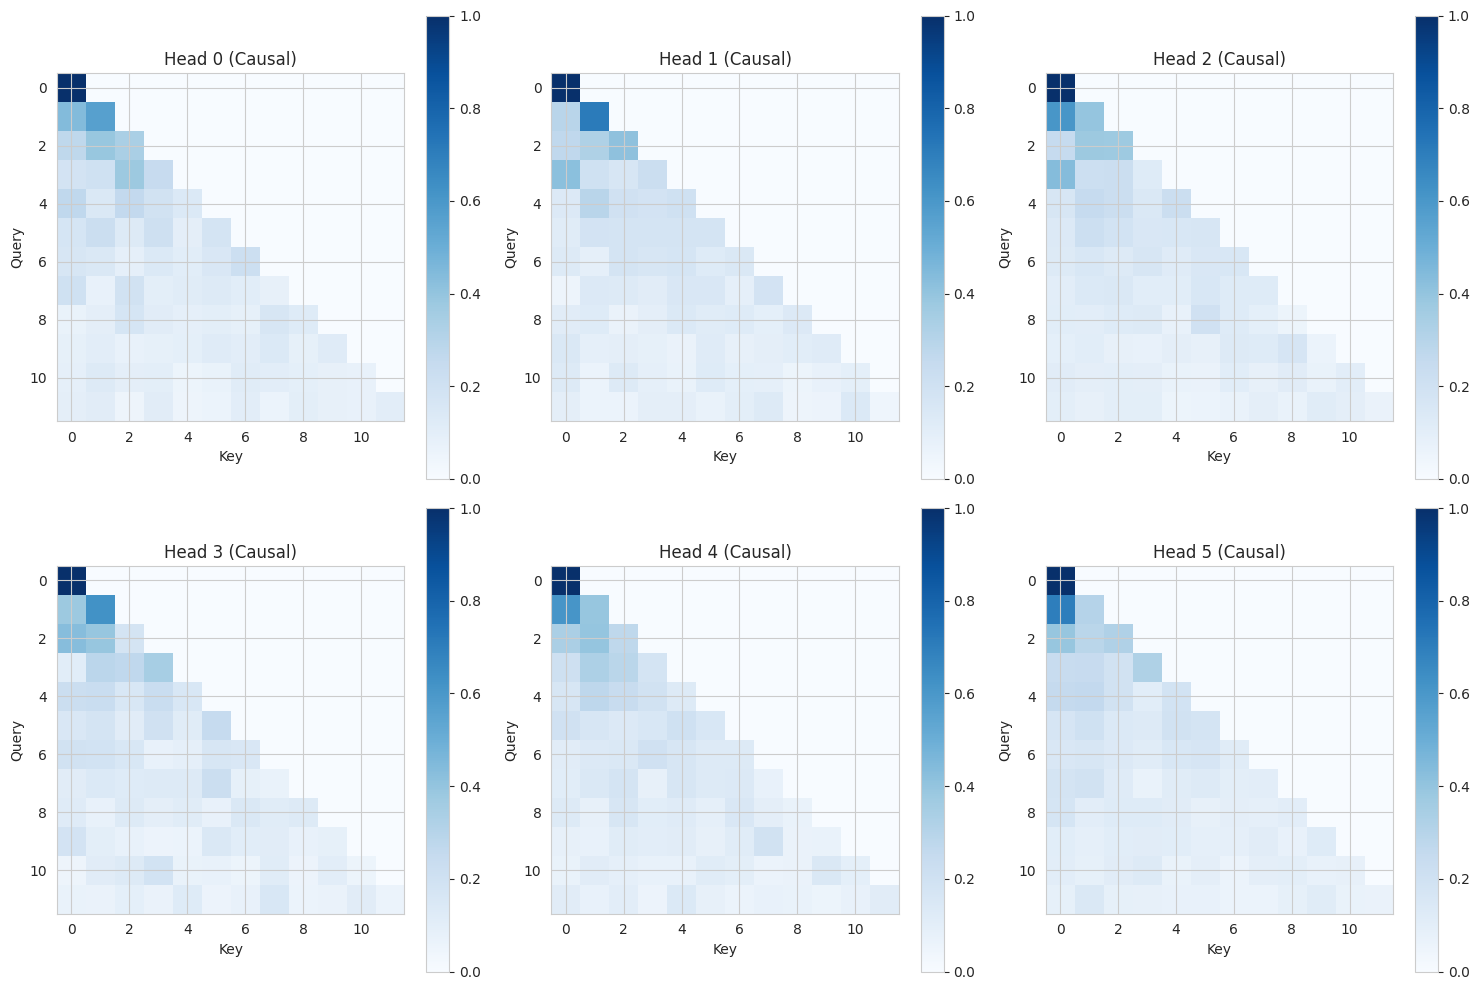

All heads respect the causal mask!
But each learns different patterns within the allowed region.


In [6]:
# Show causal masking across multiple heads
seq_len = 12
n_head = 6
causal_attn_multi = CausalAttnWithWeights(n_embd=192, n_head=n_head, dropout=0.0)
causal_attn_multi.eval()

x = torch.randn(1, seq_len, 192)

with torch.no_grad():
    _, weights = causal_attn_multi(x)

weights = weights.squeeze()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for head in range(n_head):
    im = axes[head].imshow(weights[head].numpy(), cmap='Blues', vmin=0, vmax=1)
    axes[head].set_title(f'Head {head} (Causal)', fontsize=12)
    axes[head].set_xlabel('Key')
    axes[head].set_ylabel('Query')
    plt.colorbar(im, ax=axes[head])

plt.tight_layout()
plt.show()

print('All heads respect the causal mask!')
print('But each learns different patterns within the allowed region.')

## Verify Masking Properties

In [7]:
# Verify key properties of causal masking
seq_len = 10
causal_attn = CausalAttnWithWeights(n_embd=128, n_head=4, dropout=0.0)
causal_attn.eval()

x = torch.randn(1, seq_len, 128)

with torch.no_grad():
    _, weights = causal_attn(x)

print('=== Causal Masking Verification ===')
print()

# Check 1: Future positions are 0
future_is_zero = True
for head in range(4):
    for i in range(seq_len):
        for j in range(i+1, seq_len):
            if weights[0, head, i, j] != 0:
                future_is_zero = False

print(f'✓ Future positions are masked (zero): {future_is_zero}')

# Check 2: Past positions can have non-zero attention
past_has_attention = (weights[0, :, 1:, :-1] > 0).any().item()
print(f'✓ Past positions have attention: {past_has_attention}')

# Check 3: Attention weights sum to 1
row_sums = weights.sum(dim=-1)
sums_to_one = torch.allclose(row_sums, torch.ones_like(row_sums), atol=1e-6)
print(f'✓ Attention weights sum to 1: {sums_to_one}')

# Check 4: First position only attends to itself
first_pos_self = torch.allclose(
    weights[0, :, 0, 0], 
    torch.ones(4), 
    atol=1e-6
)
print(f'✓ First position only self-attends: {first_pos_self}')

# Check 5: Last position can attend to all
last_pos_all = (weights[0, :, -1, :] > 0).all().item()
print(f'✓ Last position attends to all: {last_pos_all}')

print()
print('✅ All causal masking properties verified!')

=== Causal Masking Verification ===

✓ Future positions are masked (zero): True
✓ Past positions have attention: True
✓ Attention weights sum to 1: True
✓ First position only self-attends: True
✓ Last position attends to all: True

✅ All causal masking properties verified!


## Variable Sequence Lengths

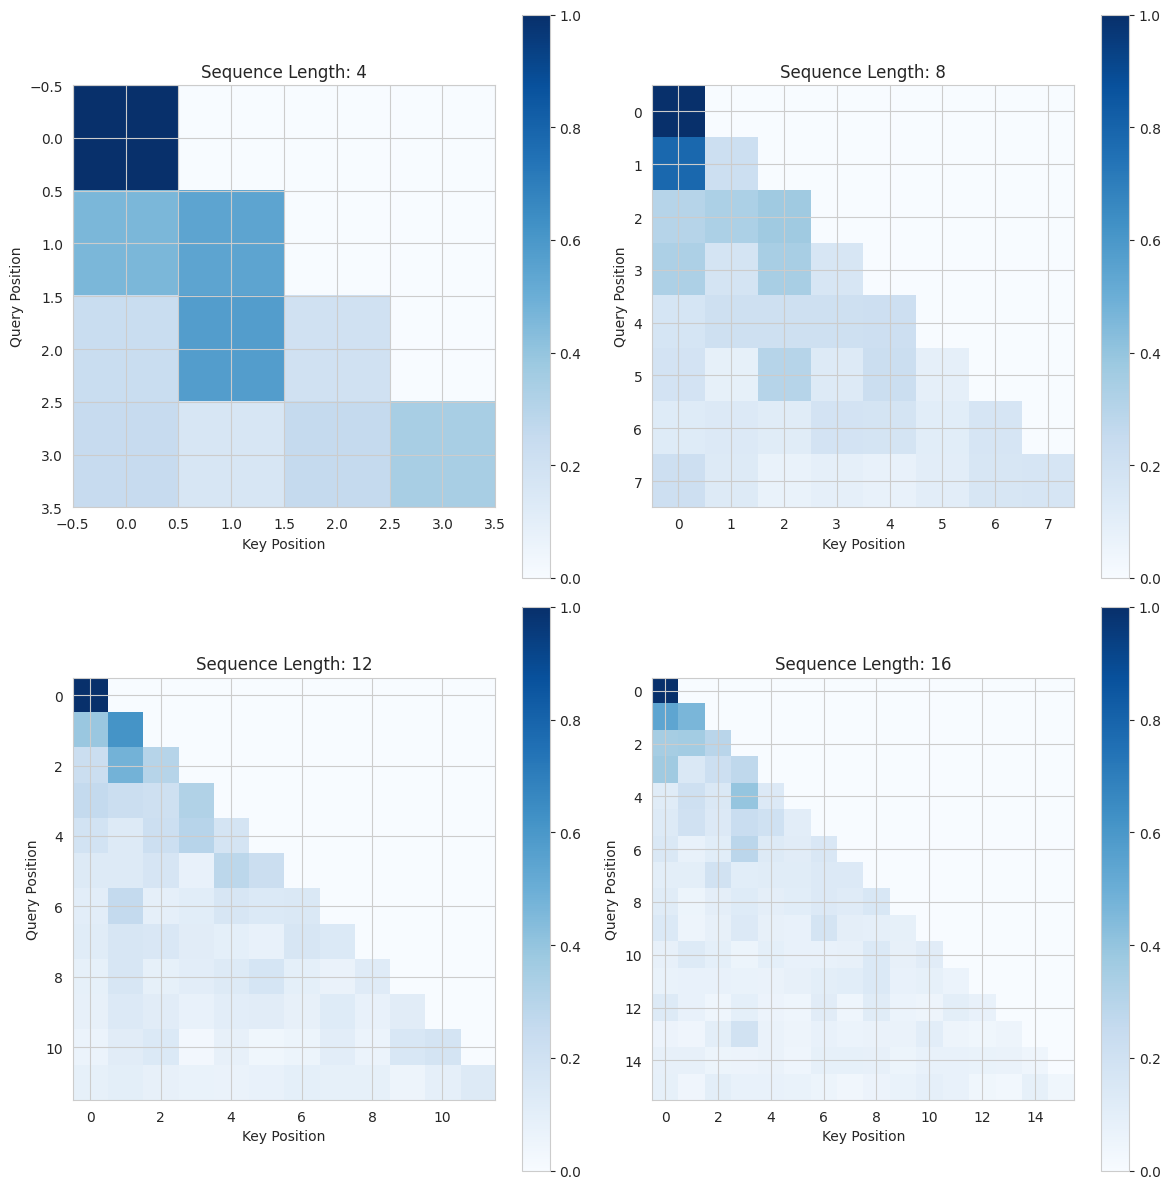

Causal masking adapts to any sequence length!


In [8]:
# Test with different sequence lengths
causal_attn = CausalAttnWithWeights(n_embd=64, n_head=2, n_positions=20, dropout=0.0)
causal_attn.eval()

seq_lengths = [4, 8, 12, 16]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, seq_len in enumerate(seq_lengths):
    x = torch.randn(1, seq_len, 64)
    
    with torch.no_grad():
        _, weights = causal_attn(x)
    
    im = axes[idx].imshow(weights[0, 0].numpy(), cmap='Blues', vmin=0, vmax=1)
    axes[idx].set_title(f'Sequence Length: {seq_len}', fontsize=12)
    axes[idx].set_xlabel('Key Position')
    axes[idx].set_ylabel('Query Position')
    plt.colorbar(im, ax=axes[idx])

plt.tight_layout()
plt.show()

print('Causal masking adapts to any sequence length!')

## Verify Your Implementation

In [9]:
# Quick verification
attn = CausalMultiHeadAttention(n_embd=768, n_head=12, n_positions=1024, dropout=0.1)
x = torch.randn(2, 10, 768)
output = attn(x)

print('✓ Module initializes correctly')
print(f'✓ Forward pass works: {x.shape} → {output.shape}')
print(f'✓ Causal mask registered: {"bias" in dict(attn.named_buffers())}')
print(f'✓ Mask is lower triangular: {torch.allclose(attn.bias, torch.tril(attn.bias))}')
print('\n✅ Basic functionality verified!')
print('\nRun "python -m pytest test_causal_masking.py -v" for complete validation.')

✓ Module initializes correctly
✓ Forward pass works: torch.Size([2, 10, 768]) → torch.Size([2, 10, 768])
✓ Causal mask registered: True
✓ Mask is lower triangular: True

✅ Basic functionality verified!

Run "python -m pytest test_causal_masking.py -v" for complete validation.
